<a href="https://colab.research.google.com/github/qkrwoghd04/Image-text_fusion_for_binary_classification_using_BERT-ViT/blob/master/vit_classification_using_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install torchinfo
!pip install ray
!pip install -U tensorboardx

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import os
import sys
import tempfile
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
# Image Classification
import torch
from torchvision.transforms import v2
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import argparse
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
from functools import partial
import os
from pathlib import Path
import torchvision.transforms as transforms
from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint, Result
from ray.tune.schedulers import ASHAScheduler
from ray.tune.examples.mnist_pytorch import train_mnist
from ray.tune import ResultGrid,CLIReporter
import ray.cloudpickle as pickle

In [3]:
# Training device:
device = 'cuda'

# hyperparameter
learning_rate = 1e-4
batch_size = 64
epochs = 20
# based on paper's "attention is all you need"
BATCH_SIZE = 64
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2 #(3 * 16 * 16) = 768
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2) #((224*224)/

In [43]:
class CustomImageDataset():
  def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_file = pd.read_csv(os.path.join(img_dir, csv_file))
        self.csv_file = csv_file
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

  def __len__(self):
    return len(self.img_file)

  def __getitem__(self, index):
    # 레이블을 기반으로 서브폴더 경로 결정
    label = self.img_file.iloc[index, 2]
    subfolder = 'Sleep' if label == 'Sleep' else 'Fall'
    if "train" in self.csv_file:
      img_path = os.path.join(self.img_dir, 'train', subfolder, self.img_file.iloc[index, 0])
    elif "test" in self.csv_file:
      img_path = os.path.join(self.img_dir, 'test', subfolder, self.img_file.iloc[index, 0])
    if(label == "Sleep"):
       label = 0
    else: label = 1
    image = read_image(img_path)
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)

    return image, label

In [54]:
def image_transform():

  H, W = 224, 224
  img = torch.randint(0, 256, size=(3, H, W), dtype=torch.uint8)

  transforms = v2.Compose([
      v2.RandomResizedCrop(size=(224, 224), antialias=True),
      v2.RandomPhotometricDistort(p=0.2),
      v2.RandomHorizontalFlip(p=0.2),
      v2.ToDtype(torch.float32, scale=True),
      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])


  return transforms


def visualize_data(train_dataloader):
    # 이미지와 정답(label)을 표시합니다.
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]

    if img.dim() == 3 and img.size(0) == 3:
        img = img.permute(1, 2, 0)

    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")

In [48]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(1, NUM_OF_PATCHES + 1, embedding_dim), requires_grad=True)

    def forward(self, x):
        batch_size = x.size(0)
        class_token_embeddings = self.class_token_embeddings.repeat(batch_size, 1, 1)
        x = self.conv_layer(x)
        x = x.permute(0, 2, 3, 1)
        x = self.flatten_layer(x)
        x = torch.cat((class_token_embeddings, x), dim=1)
        x = x + self.position_embeddings
        return x

In [49]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dims = 768, num_heads = 12, attn_dropout=0.0):
        super().__init__()
        self.embedding_dims = embedding_dims
        self.num_head = num_heads
        self.attn_dropout = attn_dropout
        self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
        self.multiheadattention = nn.MultiheadAttention(num_heads = num_heads,
                                                        embed_dim = embedding_dims,
                                                        dropout = attn_dropout,
                                                        batch_first = True,
                                                        )
    def forward(self, x):
        x = self.layernorm(x)
        output,_ = self.multiheadattention(query=x, key=x, value=x, need_weights=False)
        return output

In [50]:
class MachineLearningPerceptronBlock(nn.Module):
    def __init__(self, embedding_dims, mlp_size, mlp_dropout):
        super().__init__()
        self.embedding_dims = embedding_dims
        self.mlp_size = mlp_size
        self.mlp_dropout = mlp_dropout

        self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dims, out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(p = mlp_dropout),
            nn.Linear(in_features = mlp_size, out_features = embedding_dims),
            nn.Dropout(p = mlp_dropout)
        )
    def forward(self,x):
        return self.mlp(self.layernorm(x))

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dims = 768,
                 mlp_dropout=0.1,
                 attn_dropout = 0.0,
                 mlp_size = 3072,
                 num_heads = 12,
                 ):
        super().__init__()

        self.mas_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims, num_heads = num_heads, attn_dropout=attn_dropout,)

        self.mlp_block = MachineLearningPerceptronBlock(embedding_dims=embedding_dims, mlp_size=mlp_size, mlp_dropout=mlp_dropout,)
    def forward(self, x):
        x = self.mas_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [63]:
class vit_model(nn.Module):
    def __init__(self, img_size = 224, in_channels = 3, patch_size = 16, embedding_dims = 768, num_transformer_layers = 12, mlp_dropout = 0.1, attn_dropout = 0.0, mlp_size = 3072, num_heads = 12, num_classes = 2):
        super().__init__()

        self.patch_embedding_layer = PatchEmbeddingLayer(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dims)

        self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims, mlp_dropout=mlp_dropout, attn_dropout=attn_dropout, mlp_size=mlp_size, num_heads=num_heads) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims), nn.Linear(in_features = embedding_dims, out_features = num_classes))
    def forward(self, x):
        return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])


In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for data, label in tqdm(dataloader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = loss_fn(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(dataloader)
            epoch_loss += loss / len(dataloader)

        print(
            f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}\n"
        )

In [55]:
file_path = r"/content/drive/MyDrive/image_dataset/processed/"
train_data_csv = "train_captions.csv"
test_data_csv = "test_captions.csv"
transform = image_transform()
train_dataset = CustomImageDataset(csv_file=train_data_csv, img_dir=file_path, transform=transform,)
# 트레이닝과 검증 데이터셋 크기 계산
total_train = len(train_dataset)
val_size = int(0.20 * total_train)
train_size = total_train - val_size

# 데이터셋 분할
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
test_dataset = CustomImageDataset(csv_file=test_data_csv, img_dir=file_path, transform=transform,)
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=1)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


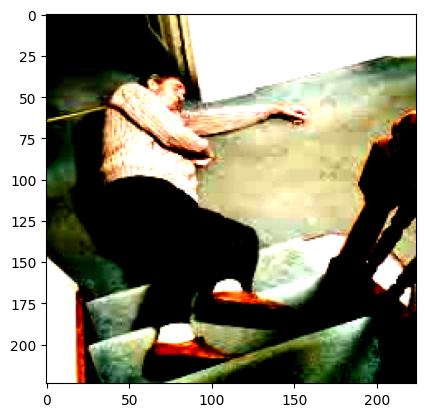

Label: 1


In [56]:
visualize_data(train_dataloader)

Feature batch shape: torch.Size([40, 3, 224, 224])
Labels batch shape: torch.Size([40])


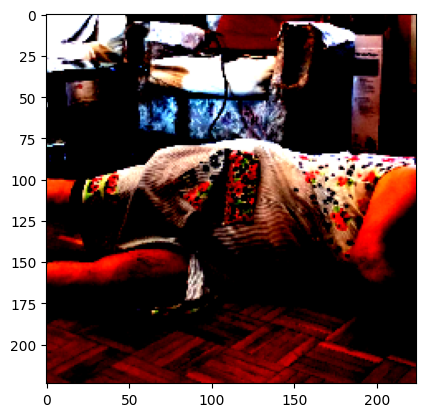

Label: 1


In [57]:
visualize_data(test_dataloader)

In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vit_model().to(device)
summary(model, input_size=(batch_size, IMAGE_CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))

Layer (type:depth-idx)                                  Output Shape              Param #
vit_model                                               [64, 2]                   --
├─PatchEmbeddingLayer: 1-1                              [64, 197, 768]            152,064
│    └─Conv2d: 2-1                                      [64, 768, 14, 14]         590,592
│    └─Flatten: 2-2                                     [64, 196, 768]            --
├─Sequential: 1-2                                       [64, 197, 768]            --
│    └─TransformerBlock: 2-3                            [64, 197, 768]            --
│    │    └─MultiHeadSelfAttentionBlock: 3-1            [64, 197, 768]            2,363,904
│    │    └─MachineLearningPerceptronBlock: 3-2         [64, 197, 768]            4,723,968
│    └─TransformerBlock: 2-4                            [64, 197, 768]            --
│    │    └─MultiHeadSelfAttentionBlock: 3-3            [64, 197, 768]            2,363,904
│    │    └─MachineLearningPe

In [15]:
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# train_loop(train_dataloader, model, loss_fn, optimizer)

In [65]:
CHECKPOINT_FREQ = 3
CHECKPOINT_DIR = "./drive/MyDrive/ray_results/tune_analyzing_results/checkpoints"  # 영구 저장소 경로 설정
def train_func(config):
  start = 1
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model = vit_model().to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

  # #Define checkpoint
  checkpoint = train.get_checkpoint()
  if checkpoint:
      with checkpoint.as_directory() as checkpoint_dir:
          checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
          print(checkpoint_dict)
          start = checkpoint_dict["epoch"] + 1
          model.load_state_dict(checkpoint_dict["model_state"])

  train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=1)
  val_dataloader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, num_workers=1)

  #model training
  for epoch in range(start, config["epochs"] + 1):  # loop over the dataset multiple times
      running_loss = 0.0
      epoch_steps = 0
      for i, data in enumerate(train_dataloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          epoch_steps += 1
          if i % 2000 == 1999:  # print every 2000 mini-batches
              print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
              running_loss = 0.0

      # Validation loss
      val_loss = 0.0
      val_steps = 0
      total = 0
      correct = 0
      for i, data in enumerate(val_dataloader, 0):
          with torch.no_grad():
              inputs, labels = data
              inputs, labels = inputs.to(device), labels.to(device)

              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              loss = loss_fn(outputs, labels)
              val_loss += loss.cpu().numpy()
              val_steps += 1
      metrics = {
            "loss": running_loss / len(train_dataloader),
            "val_loss": val_loss / len(val_dataloader),
            "mean_accuracy": correct / total
      }
      with tempfile.TemporaryDirectory() as tempdir:
          print(os.path.join(tempdir, "checkpoint.pt"))
          torch.save(
              {"epoch": epoch, "model_state": model.state_dict()},
              os.path.join(tempdir, "checkpoint.pt"),
          )
          train.report(metrics=metrics, checkpoint=Checkpoint.from_directory(tempdir))

In [66]:
def test_accuracy(model, device="cpu"):
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [68]:
storage_path = "/content/drive/MyDrive/ray_results"
exp_name = "tune_analyzing_results"
trainable_with_resources = tune.with_resources(train_func, {"cpu":4 , "gpu":1, "accelerator_type:T4":1})
tuner = tune.Tuner(
    trainable_with_resources,
    param_space={
        "lr": tune.loguniform(1e-4, 1e-5),
        "batch_size": tune.choice([16, 32, 64]),
        "epochs": 20,
        "should_checkpoint":True,

    },
    run_config=train.RunConfig(
        name=exp_name,
        stop={"training_iteration": 2},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="mean_accuracy",
            num_to_keep=3
        ),
        storage_path=storage_path,
    ),
    tune_config=tune.TuneConfig(mode="max", metric="mean_accuracy", num_samples=8, max_concurrent_trials=4),
)
result_grid: ResultGrid = tuner.fit()


+-----------------------------------------------------------+
| Configuration for experiment     tune_analyzing_results   |
+-----------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator    |
| Scheduler                        FIFOScheduler            |
| Number of trials                 8                        |
+-----------------------------------------------------------+

View detailed results here: /content/drive/MyDrive/ray_results/tune_analyzing_results
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-05-07_08-12-58_277646_383/artifacts/2024-05-07_10-00-47/tune_analyzing_results/driver_artifacts`

Trial status: 4 PENDING
Current time: 2024-05-07 10:00:47. Total running time: 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
+----------------------------------------------------------------+
| Trial name               status              lr     batch_si

(train_func pid=37039) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=37039)   self.pid = os.fork()


(train_func pid=37039) /tmp/tmpedxtoku4/checkpoint.pt


(train_func pid=37039) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00000_0_batch_size=16,lr=0.0000_2024-05-07_10-00-47/checkpoint_000000)



Trial status: 1 RUNNING | 3 PENDING
Current time: 2024-05-07 10:01:17. Total running time: 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00000 with mean_accuracy=0.5375 and params={'lr': 1.4411736622876433e-05, 'batch_size': 16, 'epochs': 20, 'should_checkpoint': True}
+-----------------------------------------------------------------------------------------------------------------------------+
| Trial name               status              lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-----------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00000   RUNNING    1.44117e-05             16   0.5375        1            15.6424   0.829898     0.720436 |
| train_func_ad5ec_00001   PENDING    2.55248e-05             64                                                              |
| train_func_ad5ec_00002   P

(train_func pid=37039) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00000_0_batch_size=16,lr=0.0000_2024-05-07_10-00-47/checkpoint_000001)



Trial train_func_ad5ec_00001 started with configuration:
+-----------------------------------------------+
| Trial train_func_ad5ec_00001 config           |
+-----------------------------------------------+
| batch_size                                 64 |
| epochs                                     20 |
| lr                                      3e-05 |
| should_checkpoint                           1 |
+-----------------------------------------------+


(train_func pid=37290) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=37290)   self.pid = os.fork()


(train_func pid=37290) /tmp/tmpmy9qfrsr/checkpoint.pt


(train_func pid=37290) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00001_1_batch_size=64,lr=0.0000_2024-05-07_10-00-47/checkpoint_000000)



Trial status: 1 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-05-07 10:01:47. Total running time: 1min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00000 with mean_accuracy=0.675 and params={'lr': 1.4411736622876433e-05, 'batch_size': 16, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00001   RUNNING      2.55248e-05             64   0.6125        1            16.7478   0.975305     0.716771 |
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |


(train_func pid=37290) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00001_1_batch_size=64,lr=0.0000_2024-05-07_10-00-47/checkpoint_000001)



Trial train_func_ad5ec_00002 started with configuration:
+-----------------------------------------------+
| Trial train_func_ad5ec_00002 config           |
+-----------------------------------------------+
| batch_size                                 16 |
| epochs                                     20 |
| lr                                      7e-05 |
| should_checkpoint                           1 |
+-----------------------------------------------+


(train_func pid=37549) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=37549)   self.pid = os.fork()



Trial status: 2 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-05-07 10:02:18. Total running time: 1min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00001 with mean_accuracy=0.6875 and params={'lr': 2.552484762784329e-05, 'batch_size': 64, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00002   RUNNING      6.98466e-05             16                                                              |
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |

(train_func pid=37549) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00002_2_batch_size=16,lr=0.0001_2024-05-07_10-00-47/checkpoint_000000)


(train_func pid=37549) /tmp/tmppu6odtko/checkpoint.pt

Trial train_func_ad5ec_00002 completed after 2 iterations at 2024-05-07 10:02:36. Total running time: 1min 48s
+-----------------------------------------------------------+
| Trial train_func_ad5ec_00002 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000001 |
| time_this_iter_s                                 14.95942 |
| time_total_s                                     30.67757 |
| training_iteration                                      2 |
| loss                                              1.17203 |
| mean_accuracy                                        0.55 |
| val_loss                                          0.82152 |
+-----------------------------------------------------------+


(train_func pid=37549) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00002_2_batch_size=16,lr=0.0001_2024-05-07_10-00-47/checkpoint_000001)



Trial train_func_ad5ec_00003 started with configuration:
+-----------------------------------------------+
| Trial train_func_ad5ec_00003 config           |
+-----------------------------------------------+
| batch_size                                 64 |
| epochs                                     20 |
| lr                                      1e-05 |
| should_checkpoint                           1 |
+-----------------------------------------------+


(train_func pid=37803) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=37803)   self.pid = os.fork()



Trial status: 3 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-05-07 10:02:48. Total running time: 2min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00001 with mean_accuracy=0.6875 and params={'lr': 2.552484762784329e-05, 'batch_size': 64, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00003   RUNNING      1.10544e-05             64                                                              |
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |


(train_func pid=37803) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00003_3_batch_size=64,lr=0.0000_2024-05-07_10-00-47/checkpoint_000000)


(train_func pid=37803) /tmp/tmpm6jsv91j/checkpoint.pt

Trial train_func_ad5ec_00003 completed after 2 iterations at 2024-05-07 10:03:12. Total running time: 2min 25s
+-----------------------------------------------------------+
| Trial train_func_ad5ec_00003 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000001 |
| time_this_iter_s                                 15.95195 |
| time_total_s                                     31.63893 |
| training_iteration                                      2 |
| loss                                              0.67205 |
| mean_accuracy                                        0.55 |
| val_loss                                          0.64465 |
+-----------------------------------------------------------+


(train_func pid=37803) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00003_3_batch_size=64,lr=0.0000_2024-05-07_10-00-47/checkpoint_000001)



Trial status: 4 TERMINATED | 4 PENDING
Current time: 2024-05-07 10:03:18. Total running time: 2min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00001 with mean_accuracy=0.6875 and params={'lr': 2.552484762784329e-05, 'batch_size': 64, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |
| train_func_ad5ec_00001   TERMINATED   2.55248e-05             64   0.6875        2            31.227    0.752027     0.614891 |
| train_fun

(train_func pid=38056) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=38056)   self.pid = os.fork()


(train_func pid=38056) /tmp/tmpi3i2o3e9/checkpoint.pt


(train_func pid=38056) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00004_4_batch_size=32,lr=0.0000_2024-05-07_10-01-23/checkpoint_000000)



Trial status: 4 TERMINATED | 1 RUNNING | 3 PENDING
Current time: 2024-05-07 10:03:48. Total running time: 3min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00001 with mean_accuracy=0.6875 and params={'lr': 2.552484762784329e-05, 'batch_size': 64, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00004   RUNNING      3.00043e-05             32   0.5           1            15.7989   1.15814      0.974533 |
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |


(train_func pid=38056) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00004_4_batch_size=32,lr=0.0000_2024-05-07_10-01-23/checkpoint_000001)



Trial train_func_ad5ec_00005 started with configuration:
+-----------------------------------------------+
| Trial train_func_ad5ec_00005 config           |
+-----------------------------------------------+
| batch_size                                 64 |
| epochs                                     20 |
| lr                                      9e-05 |
| should_checkpoint                           1 |
+-----------------------------------------------+


(train_func pid=38313) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=38313)   self.pid = os.fork()


(train_func pid=38313) /tmp/tmppzvtqtqf/checkpoint.pt


(train_func pid=38313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00005_5_batch_size=64,lr=0.0001_2024-05-07_10-02-00/checkpoint_000000)



Trial status: 5 TERMINATED | 1 RUNNING | 2 PENDING
Current time: 2024-05-07 10:04:18. Total running time: 3min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00001 with mean_accuracy=0.6875 and params={'lr': 2.552484762784329e-05, 'batch_size': 64, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00005   RUNNING      8.91561e-05             64   0.5           1            15.4294   2.42013      1.2017   |
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |

(train_func pid=38313) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00005_5_batch_size=64,lr=0.0001_2024-05-07_10-02-00/checkpoint_000001)



Trial train_func_ad5ec_00006 started with configuration:
+-----------------------------------------------+
| Trial train_func_ad5ec_00006 config           |
+-----------------------------------------------+
| batch_size                                 32 |
| epochs                                     20 |
| lr                                      7e-05 |
| should_checkpoint                           1 |
+-----------------------------------------------+


(train_func pid=38565) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=38565)   self.pid = os.fork()


(train_func pid=38565) /tmp/tmpf8n2jkwa/checkpoint.pt


(train_func pid=38565) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00006_6_batch_size=32,lr=0.0001_2024-05-07_10-02-36/checkpoint_000000)



Trial status: 6 TERMINATED | 1 RUNNING | 1 PENDING
Current time: 2024-05-07 10:04:48. Total running time: 4min 0s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00001 with mean_accuracy=0.6875 and params={'lr': 2.552484762784329e-05, 'batch_size': 64, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00006   RUNNING      7.12788e-05             32   0.5125        1            15.3446   1.31359      0.913928 |
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |


(train_func pid=38565) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00006_6_batch_size=32,lr=0.0001_2024-05-07_10-02-36/checkpoint_000001)



Trial train_func_ad5ec_00007 started with configuration:
+-----------------------------------------------+
| Trial train_func_ad5ec_00007 config           |
+-----------------------------------------------+
| batch_size                                 16 |
| epochs                                     20 |
| lr                                      4e-05 |
| should_checkpoint                           1 |
+-----------------------------------------------+


(train_func pid=38818) /usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
(train_func pid=38818)   self.pid = os.fork()



Trial status: 7 TERMINATED | 1 RUNNING
Current time: 2024-05-07 10:05:18. Total running time: 4min 30s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00006 with mean_accuracy=0.7125 and params={'lr': 7.127878148674036e-05, 'batch_size': 32, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00007   RUNNING      4.02422e-05             16                                                              |
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |
| train_fun

(train_func pid=38818) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00007_7_batch_size=16,lr=0.0000_2024-05-07_10-03-12/checkpoint_000000)


(train_func pid=38818) /tmp/tmpssj6dw26/checkpoint.pt

Trial train_func_ad5ec_00007 completed after 2 iterations at 2024-05-07 10:05:38. Total running time: 4min 51s
+-----------------------------------------------------------+
| Trial train_func_ad5ec_00007 result                       |
+-----------------------------------------------------------+
| checkpoint_dir_name                     checkpoint_000001 |
| time_this_iter_s                                 15.85299 |
| time_total_s                                     31.55419 |
| training_iteration                                      2 |
| loss                                              1.08384 |
| mean_accuracy                                      0.5125 |
| val_loss                                          1.02127 |
+-----------------------------------------------------------+


(train_func pid=38818) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/content/drive/MyDrive/ray_results/tune_analyzing_results/train_func_ad5ec_00007_7_batch_size=16,lr=0.0000_2024-05-07_10-03-12/checkpoint_000001)
2024-05-07 10:05:40,755	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/content/drive/MyDrive/ray_results/tune_analyzing_results' in 1.9968s.



Trial status: 8 TERMINATED
Current time: 2024-05-07 10:05:40. Total running time: 4min 53s
Logical resource usage: 4.0/8 CPUs, 1.0/1 GPUs (1.0/1.0 accelerator_type:T4)
Current best trial: ad5ec_00006 with mean_accuracy=0.7125 and params={'lr': 7.127878148674036e-05, 'batch_size': 32, 'epochs': 20, 'should_checkpoint': True}
+-------------------------------------------------------------------------------------------------------------------------------+
| Trial name               status                lr     batch_size      acc     iter     total time (s)       loss     val_loss |
+-------------------------------------------------------------------------------------------------------------------------------+
| train_func_ad5ec_00000   TERMINATED   1.44117e-05             16   0.675         2            30.3194   0.6778       0.620211 |
| train_func_ad5ec_00001   TERMINATED   2.55248e-05             64   0.6875        2            31.227    0.752027     0.614891 |
| train_func_ad5ec_0000

In [76]:
num_results = len(result_grid)
print("Number of results:", num_results)

Number of results: 8


In [77]:
# Iterate over results
for i, result in enumerate(result_grid):
    if result.error:
        print(f"Trial #{i} had an error:", result.error)
        continue

    print(
        f"Trial #{i} finished successfully with a mean accuracy metric of:",
        result.metrics["mean_accuracy"]
    )

Trial #0 finished successfully with a mean accuracy metric of: 0.675
Trial #1 finished successfully with a mean accuracy metric of: 0.6875
Trial #2 finished successfully with a mean accuracy metric of: 0.55
Trial #3 finished successfully with a mean accuracy metric of: 0.55
Trial #4 finished successfully with a mean accuracy metric of: 0.5375
Trial #5 finished successfully with a mean accuracy metric of: 0.5125
Trial #6 finished successfully with a mean accuracy metric of: 0.7125
Trial #7 finished successfully with a mean accuracy metric of: 0.5125


In [78]:
results_df = result_grid.get_dataframe()
results_df[["training_iteration", "mean_accuracy"]]

,training_iteration,mean_accuracy
0,2,0.6750
1,2,0.6875
2,2,0.5500
3,2,0.5500
4,2,0.5375
5,2,0.5125
6,2,0.7125
7,2,0.5125


In [79]:
# Get the result with the maximum test set `mean_accuracy`
best_result: Result = result_grid.get_best_result()

In [80]:
best_result.config

{'lr': 7.127878148674036e-05,
 'batch_size': 32,
 'epochs': 20,
 'should_checkpoint': True}

In [81]:
best_result.metrics

{'loss': 0.8513396859169007,
 'val_loss': 0.6174746155738831,
 'mean_accuracy': 0.7125,
 'timestamp': 1715076301,
 'checkpoint_dir_name': 'checkpoint_000001',
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 2,
 'trial_id': 'ad5ec_00006',
 'date': '2024-05-07_10-05-02',
 'time_this_iter_s': 15.58813762664795,
 'time_total_s': 30.93269920349121,
 'pid': 38565,
 'hostname': '9b3972ec77f1',
 'node_ip': '172.28.0.12',
 'config': {'lr': 7.127878148674036e-05,
  'batch_size': 32,
  'epochs': 20,
  'should_checkpoint': True},
 'time_since_restore': 30.93269920349121,
 'iterations_since_restore': 2,
 'experiment_tag': '6_batch_size=32,lr=0.0001'}

In [82]:
result_df = best_result.metrics_dataframe
result_df[["training_iteration", "mean_accuracy", "time_total_s"]]

,training_iteration,mean_accuracy,time_total_s
0,1,0.5125,15.344562
1,2,0.7125,30.932699


In [31]:
from ray.tune.examples.mnist_pytorch import get_data_loaders

model = vit_model()

with best_result.checkpoint.as_directory() as checkpoint_dir:
    checkpoint_dict = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
    model.load_state_dict(checkpoint_dict["model_state"])

<Axes: xlabel='training_iteration'>

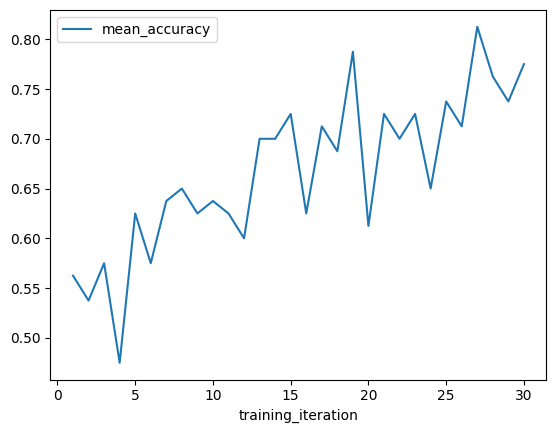

In [32]:
best_result.metrics_dataframe.plot("training_iteration", "mean_accuracy")

In [61]:
test_accuracy(model)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [33]:
import matplotlib.pyplot as plt

_, test_dataloader = get_data_loaders()
test_img = next(iter(test_dataloader))[0][0]

predicted_class = torch.argmax(model(test_img)).item()
print("Predicted Class =", predicted_class)

# Need to reshape to (batch_size, channels, width, height)
test_img = test_img.numpy().reshape((1, 1, 28, 28))
plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape((28, 28)))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 54133560.47it/s]


Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1612047.45it/s]


Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14019475.53it/s]


Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4950761.11it/s]

Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw



RuntimeError: Given groups=1, weight of size [768, 3, 16, 16], expected input[1, 1, 28, 28] to have 3 channels, but got 1 channels instead